In [1]:
import numpy as np
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC 
from sklearn.svm import LinearSVR
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

In [2]:
iris = datasets.load_iris()  

In [3]:
#seperate training sets
X=iris['data'][:, (2, 3)] #petal len and petal width
y=iris['target']

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [4]:
#Scale the data to insure no loss of small features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [8]:
#set C and alpha hyperparams for the svcs and sgdc 
c = 5
alf = 1 / (c * len(X))

lin_svc = LinearSVC(loss='hinge', C=c)
svc = SVC(kernel='linear', C=c, degree=3, coef0=0.0)
sgdc = SGDClassifier(loss='hinge', learning_rate='constant', eta0=0.001, alpha=alf, max_iter=1000, tol=1e-3)

In [9]:
#Train the models
lin_svc.fit(X_scaled,y)
svc.fit(X_scaled,y)
sgdc.fit(X_scaled,y)

SGDClassifier(alpha=0.002, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='constant', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [10]:
#slope and bias of the linear svc
w1 = -lin_svc.coef_[0, 0] / lin_svc.coef_[0, 1]
b1 = -lin_svc.intercept_[0] / lin_svc.coef_[0, 1]
#slope and bias of the svc with a linear kernel
w2 = -svc.coef_[0, 0] / svc.coef_[0, 1]
b2 = -svc.intercept_[0] / svc.coef_[0, 1]
#Slope and bias of the sgdc 
w3 = -sgdc.coef_[0, 0] / sgdc.coef_[0 ,1]
b3 = -sgdc.intercept_[0] /  sgdc.coef_[0, 1]

In [11]:
#transform the boundry decision line of the linear svc back to the original scale
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
#transform the boundry decision line of the svc with linear kernal back to the original scale
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
#transform the boundry decision line of the sgdc back to the original scale
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

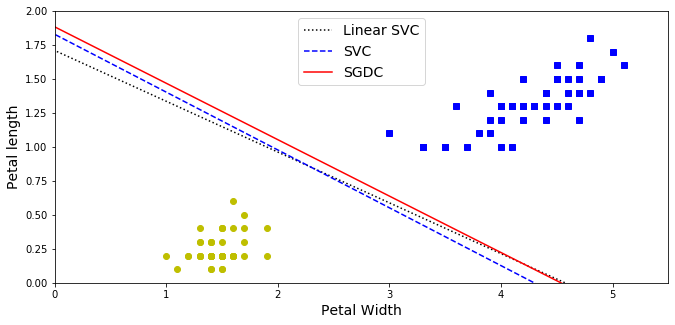

In [15]:
#plot out boundry lines 
plt.figure(figsize=[11, 5])
plt.plot(line1[:, 0], line1[:, 1], 'k:', label='Linear SVC')
plt.plot(line2[:, 0], line2[:, 1], 'b--', label='SVC')
plt.plot(line3[:, 0], line3[:, 1], 'r-', label='SGDC')
plt.plot(X[:, 0][y==1], X[:, 1][y==1], 'bs') #iris versicolor
plt.plot(X[:, 0][y==0], X[:, 1][y==0], 'yo') #iris setosa
plt.xlabel('Petal Width', fontsize=14)
plt.ylabel('Petal length', fontsize=14)
plt.legend(loc='upper center', fontsize=14)
plt.axis([0, 5.5, 0, 2])
plt.show()

# SVM Regressor on the cali housing dataset

In [42]:
#get the cali housing data set from sklearn datasets
cali = datasets.fetch_california_housing()

Xc=cali['data']
yc=cali['target']

In [51]:
#first split the data
X_train, X_test, y_train, y_test = train_test_split(Xc, yc, test_size=0.2)

#then Scale the data with the standard scaler
Xc_train_scaled = scaler.fit_transform(X_train)
Xc_test_scaled = scaler.fit_transform(X_test)

In [52]:
#make linear support vector regression model
lin_svr = LinearSVR(random_state=42)

#fit the model with data
lin_svr.fit(Xc_train_scaled, y_train)

LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
          intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
          random_state=42, tol=0.0001, verbose=0)

In [53]:
#lets measure the mean square error for metrics testing
y_pred = lin_svr.predict(Xc_train_scaled)

#measure the mean square error
mse = mean_squared_error(y_train, y_pred)
print(mse)

1.2891586079448498


In [54]:
#look at the square root of the mean square error
np.sqrt(mse)

1.1354112065436248

In [55]:
#lets make a SVR with and optimize the C and gamma parameters to see if we can do better
param_distributions = {'gamma': reciprocal(0.001, 0.1), 'C': uniform(1, 10)}
param_search = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
param_search.fit(Xc_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   4.9s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    4.8s remaining:    0.0s
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   4.7s
[CV] C=4.745401188473625, gamma=0.07969454818643928 ..................
[CV] ... C=4.745401188473625, gamma=0.07969454818643928, total=   4.8s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   4.7s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ..................
[CV] ... C=8.31993941811405, gamma=0.015751320499779724, total=   4.8s
[CV] C=8.31993941811405, gamma=0.015751320499779724 ................

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D90B2C6160>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001D9069396A0>},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [56]:
param_search.best_estimator_

SVR(C=4.745401188473625, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma=0.07969454818643928, kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [57]:
y_pred = param_search.best_estimator_.predict(Xc_train_scaled)
mse = mean_squared_error(y_train, y_pred)
print(mse)
print(np.sqrt(mse))

0.3374181157459892
0.5808770229110368


In [58]:
y_pred2 = param_search.best_estimator_.predict(Xc_test_scaled)
mse = mean_squared_error(y_test, y_pred2)
print(mse)
print(np.sqrt(mse))

0.39503129731502035
0.6285151528125796


# SVM Classifier on the MNIST Dataset

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

In [3]:
X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

In [4]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [6]:
y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.89495

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

In [8]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)

In [9]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9218166666666666

In [10]:
svm_clf = SVC(gamma="scale")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [11]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9455333333333333

In [19]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=9.316342212354758, gamma=0.023868358012715047 .................
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] .. C=9.316342212354758, gamma=0.023868358012715047, total=   0.9s
[CV] C=9.316342212354758, gamma=0.023868358012715047 .................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.8s remaining:    0.0s
[CV] .. C=9.316342212354758, gamma=0.023868358012715047, total=   0.9s
[CV] C=9.316342212354758, gamma=0.023868358012715047 .................
[CV] .. C=9.316342212354758, gamma=0.023868358012715047, total=   0.9s
[CV] C=2.673648664021987, gamma=0.019943115699098405 .................
[CV] .. C=2.673648664021987, gamma=0.019943115699098405, total=   0.9s
[CV] C=2.673648664021987, gamma=0.019943115699098405 .................
[CV] .. C=2.673648664021987, gamma=0.019943115699098405, total=   0.9s
[CV] C=2.673648664021987, gamma=0.019943115699098405 ...............

RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=SVC(C=1.0, break_ties=False, cache_size=200,
                                 class_weight=None, coef0=0.0,
                                 decision_function_shape='ovr', degree=3,
                                 gamma='scale', kernel='rbf', max_iter=-1,
                                 probability=False, random_state=None,
                                 shrinking=True, tol=0.001, verbose=False),
                   iid='deprecated', n_iter=10, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021A40B07F70>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000021A40B0CE50>},
                   pre_dispatch='2*n_jobs', random_state=None, refit=True,
                   return_train_score=False, scoring=None, verbose=2)

In [20]:
rnd_search_cv.best_estimator_

SVC(C=9.073643943335444, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.0011949000599274118, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

In [21]:
rnd_search_cv.best_score_

0.8609897322472174

In [22]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=9.073643943335444, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3,
    gamma=0.0011949000599274118, kernel='rbf', max_iter=-1, probability=False,
    random_state=None, shrinking=True, tol=0.001, verbose=False)

In [23]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9987666666666667

In [24]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9734